# Import Necessary Libraries

In [1]:
import pandas as pd 
import numpy as np 
import csv
import matplotlib.pyplot as plt 
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import time 
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from matplotlib import markers
markersList = list(markers.MarkerStyle().markers.keys())

In [2]:
mergedFrame1000 = pd.read_csv("../DataSet/engineeredFrame.csv", sep=";", decimal=".")
moreThanOnePercentColumns = pd.read_csv("../DataSet/filterFrame.csv", sep=";", decimal=".")
moreThanOnePercentColumns = moreThanOnePercentColumns.sort_values(by=["columns"], ascending=True)

mergedFrame1000["order_purchase_timestamp"] = pd.to_datetime(mergedFrame1000["order_purchase_timestamp"])
mergedFrame1000["order_delivered_customer_date"] = pd.to_datetime(mergedFrame1000["order_delivered_customer_date"])
mergedFrame1000["order_estimated_delivery_date"] = pd.to_datetime(mergedFrame1000["order_estimated_delivery_date"])
mergedFrame1000

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,NbReviews,avgReviewScore,year,orderLateInDays,orderLateBool,seller_stateEnc,payment_typeEnc,customer_stateEnc,order_statusEnc,product_category_nameEnc
0,39abd214c91bf2bf94440cb6a27e6ecb,69333c9b0482a31b66b050c1c62f8cec,22461,rio de janeiro,RJ,618b0dccb6cd114a77a84daef8d565c4,delivered,2018-04-17 13:03:22,2018-04-17 13:15:11,2018-04-18 22:58:31,...,1,1.0,2018,-32.0,0,15,1,18,2,44
1,5bdabb0382d0e9b16869f7e6b1ccda55,64b022312c6969e438f5b34b6c4325a5,86380,andira,PR,f535aa868b3671ad61668d0f6cd3a5dc,delivered,2017-05-23 17:22:06,2017-05-23 17:35:09,2017-05-24 15:39:30,...,1,5.0,2017,-14.0,0,22,1,17,2,62
2,99a50e0d375610b72d2347ba456f3217,8d0a8db3a4f4813a2226d5abccbea87e,39850,ataleia,MG,9b0f7f462c34c45144ec11e414eccab1,delivered,2017-10-23 11:33:12,2017-10-24 06:34:50,2017-10-30 20:26:46,...,1,5.0,2017,-1.0,0,22,0,10,2,71
3,b7770073b02ed1d626a027ce86a4ff82,2e43e031f10de28e557c35ef668f9396,92410,canoas,RS,df56136b8031ecd28e200bb18e6ddb2e,delivered,2017-01-26 13:15:41,2017-01-27 03:05:27,2017-01-31 19:44:07,...,3,5.0,2017,-45.0,0,15,0,22,2,32
4,17887d2c567172820aea8be8d25f34d7,19759427b9c94d4f7e25373d0410107c,24901,marica,RJ,b079c98bfa00c43a0fa13df10b7d9d2f,delivered,2018-03-18 23:01:48,2018-03-19 07:08:08,2018-03-19 19:24:49,...,1,5.0,2018,-5.0,0,22,1,18,2,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2294a7c127e0aabbd84d87b5f50adb3b,a734a69f6f4be90c1db54693cf7d0d4a,39800,teofilo otoni,MG,548593d537ea3f5e453588407a484d81,delivered,2017-11-28 19:57:43,2017-11-28 20:15:45,2017-12-04 19:38:29,...,1,5.0,2017,-1.0,0,22,1,10,2,13
49996,df710b0e7d20542f3c29d644be1f20cc,fcee78b7f020fc29669d7f2390d1b2b0,13040,campinas,SP,cc72c534117f6b66be178c5ac9235adc,delivered,2017-07-11 14:45:08,2017-07-12 02:15:54,2017-07-12 17:26:55,...,1,5.0,2017,-17.0,0,15,0,25,2,32
49997,e29fe453e172399a65852e679b7a6131,43c330d38c136f310dbf14e79b9f8d9d,19570,regente feijo,SP,0e4947dbfc032a9054b0526c61d37d1f,delivered,2017-08-03 13:24:03,2017-08-04 02:23:56,2017-08-07 18:13:45,...,1,5.0,2017,-11.0,0,20,0,25,2,32
49998,58d54b1ff5f21bb5fe6928646949ff4c,8adff52976579b096284ce43e65d6160,25040,duque de caxias,RJ,5f95f5f78f509a3af5a6c83d81c1117f,delivered,2017-08-06 13:38:15,2017-08-08 04:40:20,2017-08-14 12:47:34,...,1,3.0,2017,-7.0,0,22,0,18,2,72


In [3]:
filterC = list(moreThanOnePercentColumns[moreThanOnePercentColumns["isFilter"] == True]["columns"].values)
print(filterC)

['NbReviews', 'avgReviewScore', 'customer_stateEnc', 'nbOrders', 'orderLateBool', 'orderLateInDays', 'orderStatusBool', 'order_delivery_length', 'payment_sequential', 'payment_typeEnc', 'price', 'product_category_nameEnc', 'returningCustomers', 'review_score', 'year']


# Data Standardisation for dataset

In [4]:
X_delivered = mergedFrame1000[mergedFrame1000["order_status"] == "delivered"]
rawFrame = mergedFrame1000.dropna().filter(items=filterC)
X = mergedFrame1000.dropna().filter(items=filterC).values

std_scaler = preprocessing.StandardScaler().fit(X)
X_scaled = std_scaler.transform(X)
print(len(X_scaled))

48178


# MinMax version

In [5]:
minMaxEncoder = preprocessing.MinMaxScaler()
minMaxScaler = minMaxEncoder.fit(rawFrame.values)

X_MinMax = minMaxScaler.transform(rawFrame.values)
print(len(X_MinMax))

48178


# PCA

In [6]:
from sklearn import decomposition
n_components = 7
pca = decomposition.PCA(n_components=n_components)
pca.fit(X_scaled)

PCA(n_components=7)

In [7]:
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.2034814  0.17359222 0.09372753 0.08447815 0.07467621 0.06772569
 0.06645638]
0.7641375924783687


### Données projetées sur les composantes principales et colorée par classement state.

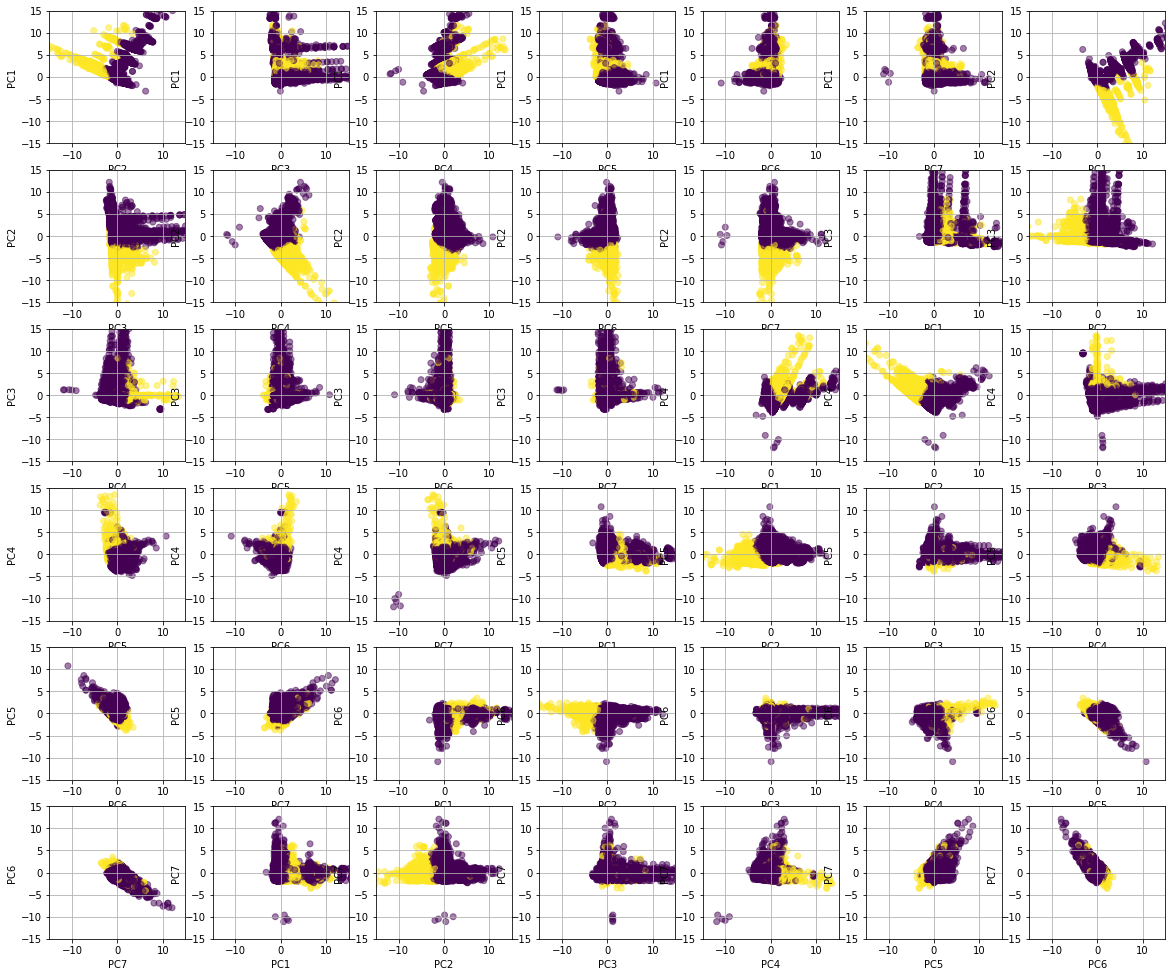

In [8]:
scatter = plt.figure(figsize=(20,20))
subplotIndex = 1



for c in range(n_components):

    # projeter X sur les composantes principales
    X__pca_projected = pca.transform(X_scaled)
    #ax = scatter.add_subplot(4, 3, (c+1))
    dimension = 'PC'+str(c+1)
    #print(dimension)
    # afficher chaque observation
    for cX in range(n_components):
        if cX != c:
            ax = scatter.add_subplot(n_components, n_components, subplotIndex)
            dimensionX = 'PC'+str(cX+1)
            ax.scatter(X__pca_projected[:, cX], X__pca_projected[:, c],  alpha=0.5, marker="o",
                # colorer en utilisant la variable 'Review Score
                #c=X_delivered.dropna().get('product_category_nameEnc'))
                c=rawFrame.dropna().get('orderLateBool'))
            ax.grid()
            ax.set_ylabel(dimension)
            ax.set_xlabel(dimensionX)
            ax.set_xlim([-15, 15])
            ax.set_ylim([-15, 15])
            subplotIndex = subplotIndex+1
    #ax.xlim([-5.5, 5.5])
    #ax.ylim([-4, 4])
    #ax.colorbar()
    #ax.show()

### Contribution de chaque variable aux composantes principales

(-1.0, 1.0)

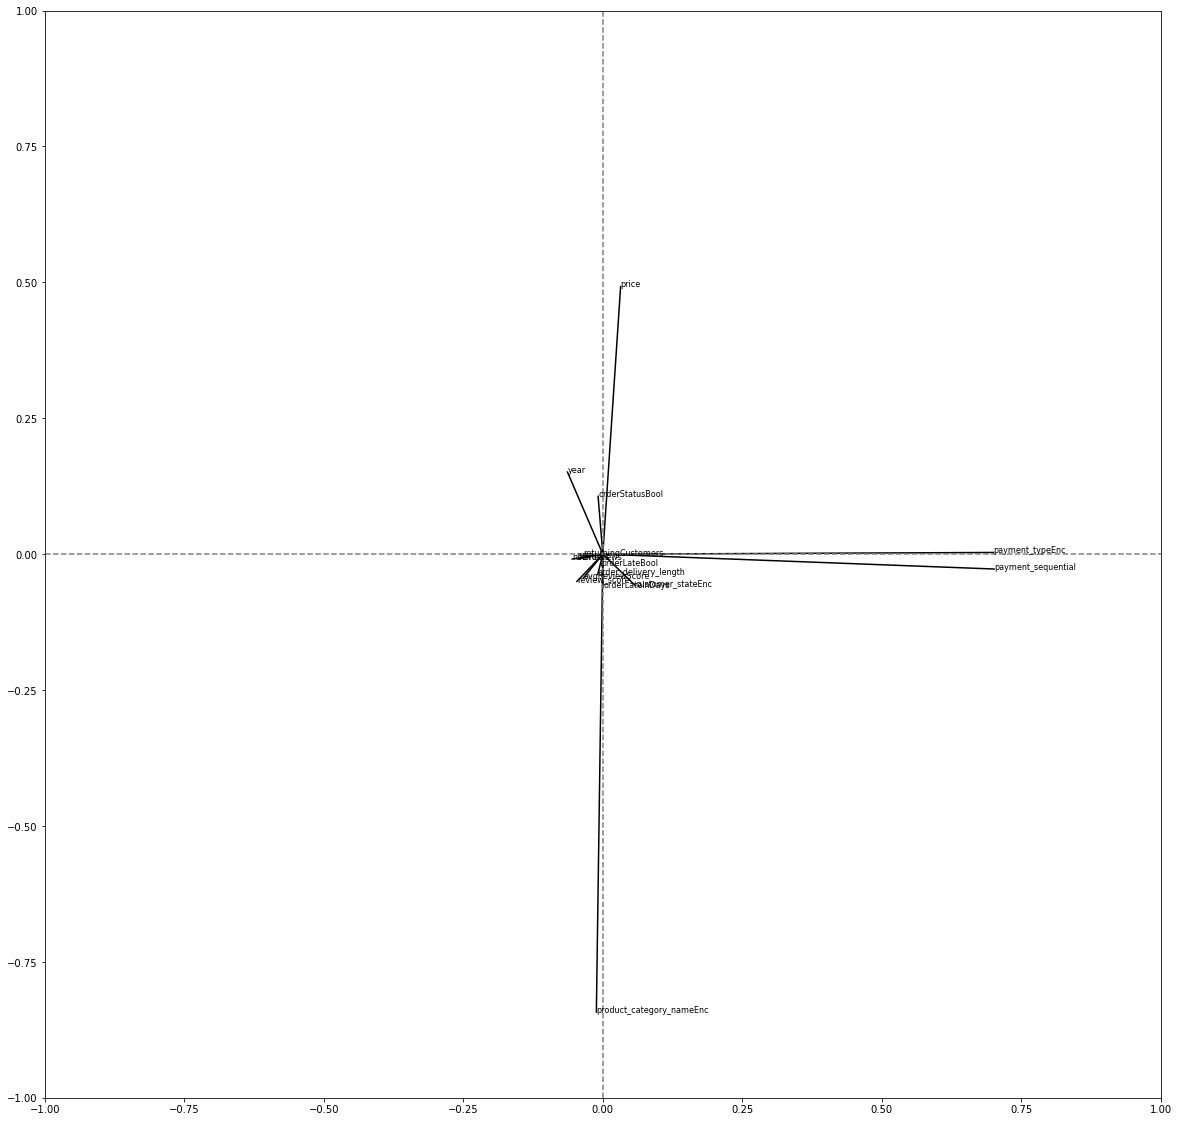

In [9]:
pcs = pca.components_

plt.figure(figsize=(20,20))

for i, (x, y) in enumerate(zip(pcs[2, :], pcs[6, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, filterC[i], fontsize='8')

# Afficher une ligne horizontale y=0
plt.plot([-1, 1], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-1, 1], color='grey', ls='--')

plt.xlim([-1, 1])
plt.ylim([-1, 1])

# NMF
### Only Positive Value and with a set of 48178 MinMaxed data

In [10]:
from sklearn import decomposition
nmf = decomposition.NMF(n_components=n_components, max_iter=10000, init="random")
nmf.fit(X_MinMax)

#print(nmf.explained_variance_ratio_)
#print(nmf.explained_variance_ratio_.sum())
print("components", nmf.components_)

components [[0.00000000e+00 1.45351671e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.77639790e-01 6.94397987e-01 4.22873086e-02
  0.00000000e+00 0.00000000e+00 1.34092811e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.59540519e+00]
 [1.94346480e-04 2.48927821e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 8.95578218e-02 2.31783032e-01 1.81964386e-02
  1.90743773e-02 7.42150947e-01 6.20557106e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.39022568e+00 9.89449614e-02 0.00000000e+00
  0.00000000e+00 2.08988244e-01 5.40379969e-01 2.25630051e-02
  0.00000000e+00 0.00000000e+00 1.25061452e-02 0.00000000e+00
  0.00000000e+00 1.54490305e+00 2.01649920e-01]
 [8.09940507e-02 0.00000000e+00 1.42160733e-01 8.57481006e-02
  0.00000000e+00 1.19429880e-01 3.05876287e-01 1.51309733e-02
  1.65435513e-03 5.83501593e-03 4.10888563e-03 7.05128034e-02
  5.82144677e-01 4.00232268e-01 2.67144532e-01]
 [0.00000000e+00 1.39409901e-02 0.00000000e+00 0.0000

### Données projetées sur les composantes principales et colorée par classement state.

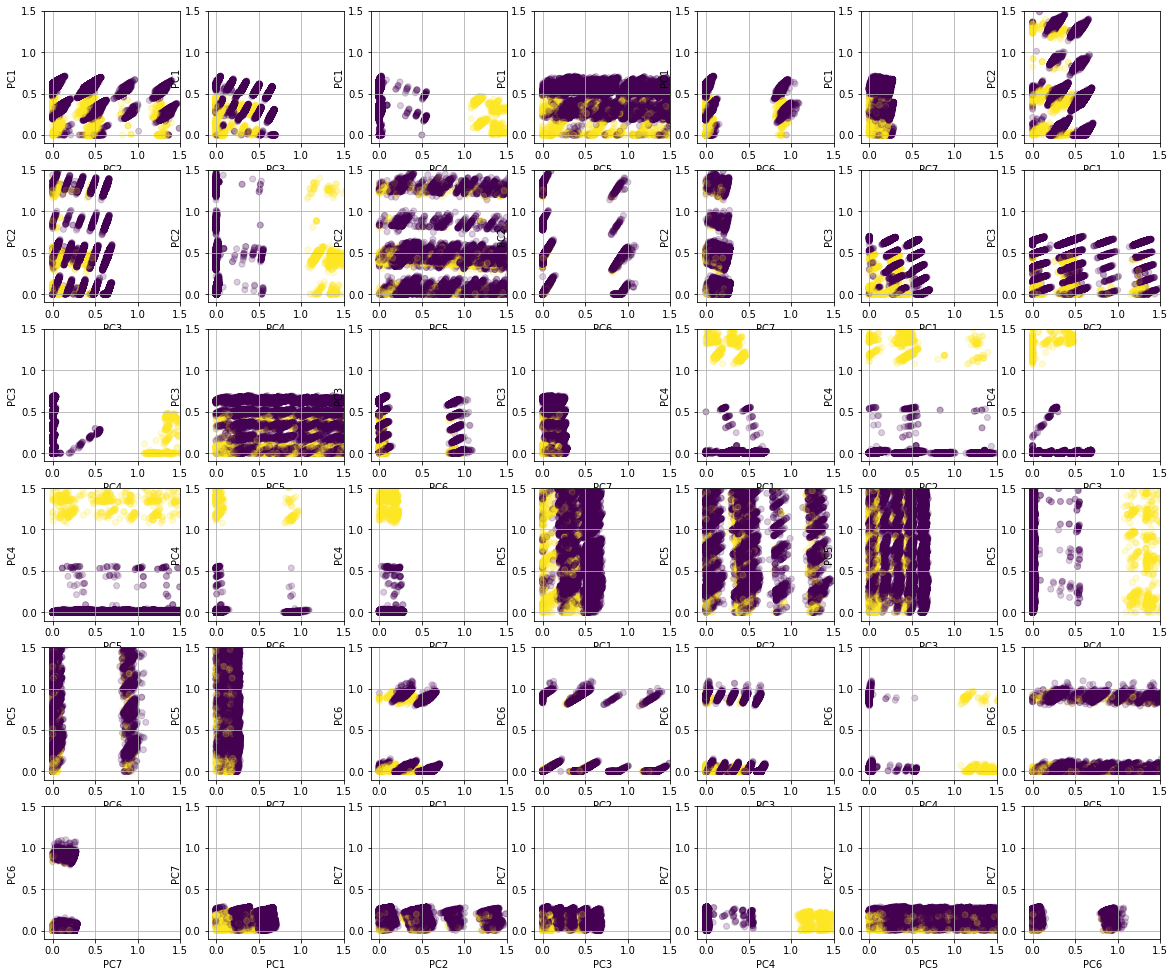

In [11]:
scatter = plt.figure(figsize=(20,20))
subplotIndex = 1
X_nmf_projected = nmf.transform(X_MinMax)

for c in range(n_components):

    # projeter X sur les composantes principales
    
    #ax = scatter.add_subplot(4, 3, (c+1))
    dimension = 'PC'+str(c+1)
    #print(dimension)
    # afficher chaque observation
    for cX in range(n_components):
        if cX != c:
            ax = scatter.add_subplot(n_components, n_components, subplotIndex)
            dimensionX = 'PC'+str(cX+1)
            ax.scatter(X_nmf_projected[:, cX], X_nmf_projected[:, c],  alpha=0.2, marker="o",
                # colorer en utilisant la variable 'Review Score
                c=rawFrame.get('returningCustomers'))
                #c=rawFrame.get('orderLateBool'))
                #c=rawFrame[:20000].get('year'))
            
                #c=X_delivered.dropna().get('returningCustomers'))
            ax.grid()
            ax.set_ylabel(dimension)
            ax.set_xlabel(dimensionX)
            ax.set_xlim([-0.1, 1.5])
            ax.set_ylim([-0.1, 1.5])
            subplotIndex = subplotIndex+1
    #ax.xlim([-5.5, 5.5])
    #ax.ylim([-4, 4])
    #ax.colorbar()
    #ax.show()

# Contribution de chaque variable aux composantes principales

(0.0, 2.0)

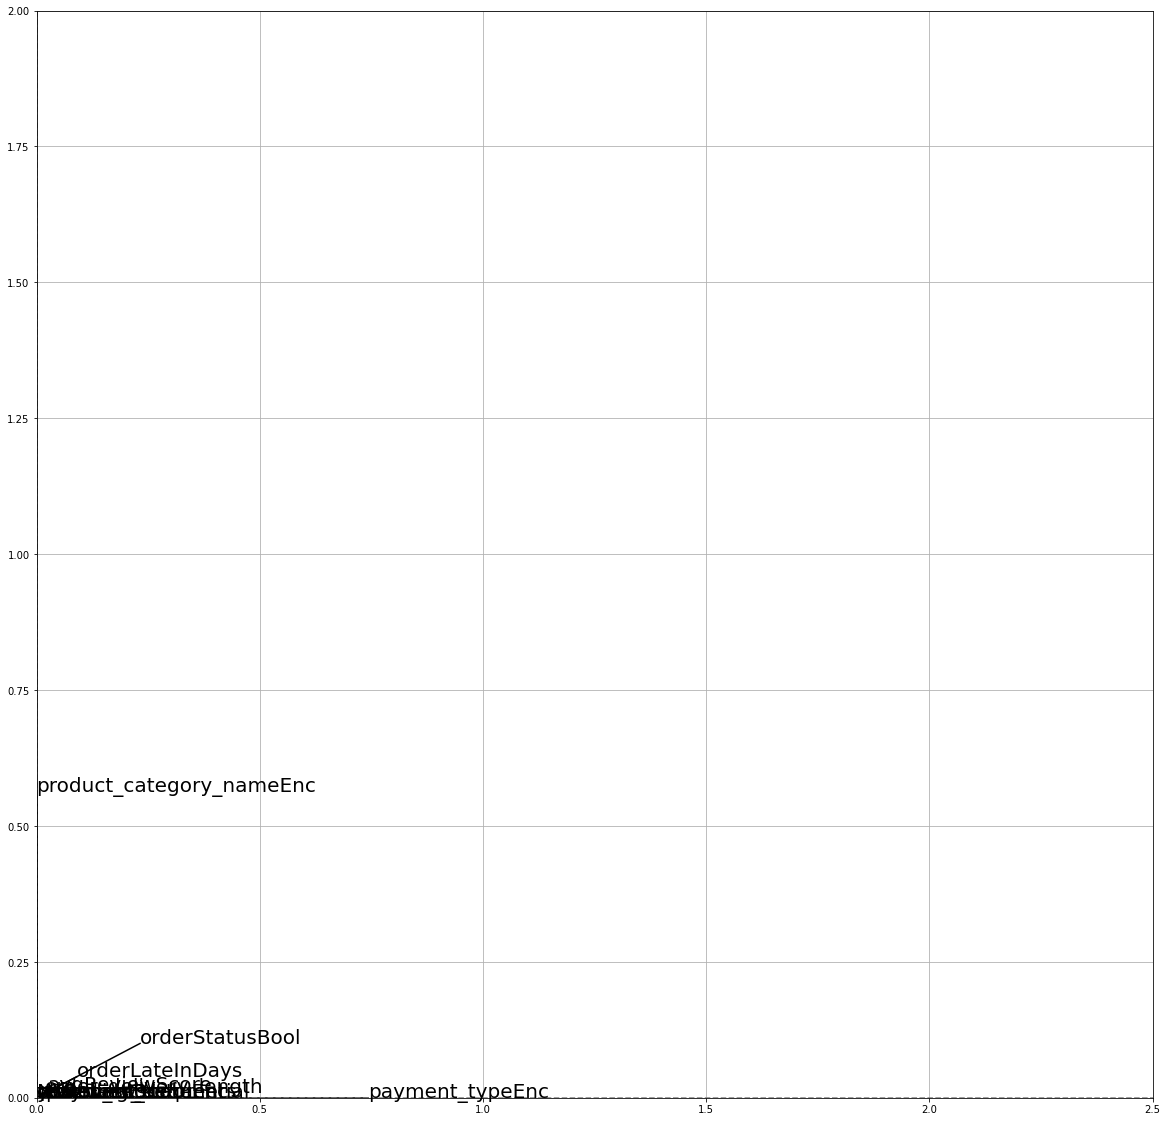

In [12]:
nmfs = nmf.components_
contribution = plt.figure(figsize=(20,20))

for i, (x, y) in enumerate(zip(nmfs[1, :], nmfs[4, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, filterC[i], fontsize='20')

# Afficher une ligne horizontale y=0
plt.plot([0, 2.5], [0, 0], color='grey', ls='--')
plt.grid()
# Afficher une ligne verticale x=0
plt.plot([0, 0], [0, 2], color='grey', ls='--')

plt.xlim([0, 2.5])
plt.ylim([0, 2])

# FactorAnalysis


In [13]:
from sklearn import decomposition
start_time = time.time()
#print(X_MinMax.shape)
factor = decomposition.FactorAnalysis(n_components=n_components, max_iter=5000)
factor.fit(X_scaled)
X_factor_projected = factor.transform(X_scaled)
print(str(time.time()-start_time))

64.52092599868774


0.7843048572540283


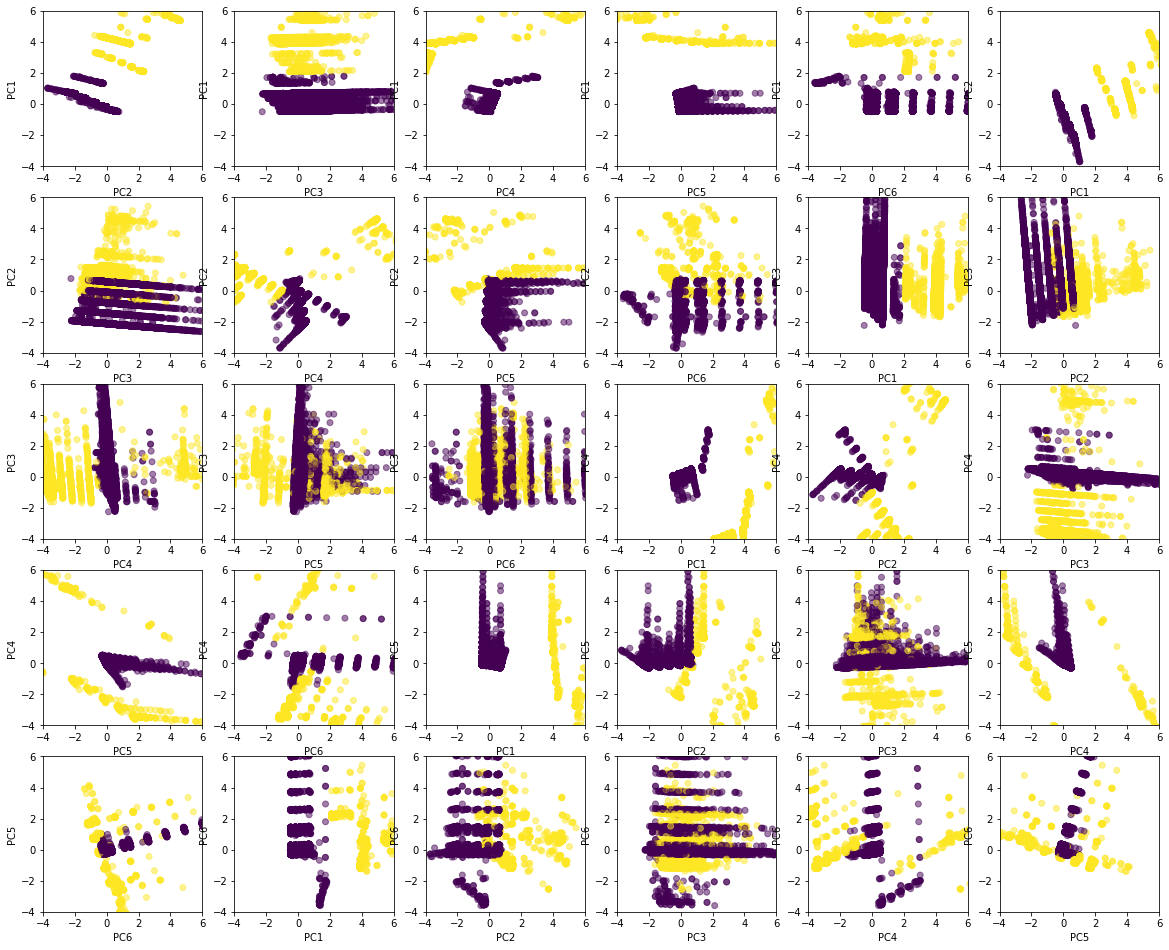

In [14]:
scatter = plt.figure(figsize=(20,20))
subplotIndex = 1
n_components = 6
start_time = time.time()

for c in range(n_components):
    
    # projeter X sur les composantes principales
    
    #ax = scatter.add_subplot(4, 3, (c+1))
    dimension = 'PC'+str(c+1)
    #print(dimension)
    # afficher chaque observation
    for cX in range(n_components):
        if cX != c:
            ax = scatter.add_subplot(n_components, n_components, subplotIndex)
            dimensionX = 'PC'+str(cX+1)
            ax.scatter(X_factor_projected[:, cX], X_factor_projected[:, c],  alpha=0.5, marker="o",
                # colorer en utilisant la variable 'Review Score
                c=rawFrame.get('returningCustomers'))
                #c=rawFrame[:5000].get('orderLateBool'))
                #c=mergedFrame1000.dropna().get('product_category_nameEnc'))
            ax.set_ylabel(dimension)
            ax.set_xlabel(dimensionX)
            ax.set_xlim([-4, 6])
            ax.set_ylim([-4, 6])
            subplotIndex = subplotIndex+1
    #ax.xlim([-5.5, 5.5])
    #ax.ylim([-4, 4])
    #ax.colorbar()
    #ax.show()
print(str(time.time()-start_time))

# Kernel PCA

In [ ]:
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
def my_scorer(estimator, X, y=None):
    X_reduced = estimator.transform(X)
    X_preimage = estimator.inverse_transform(X_reduced)
    return -1 * mean_squared_error(X, X_preimage)

start_time = time.time()
param_grid = [{
    "gamma": np.linspace(0.03, 0.05, 10),
    "kernel": ["linear", "poly", "rbf"]
}]

kernel = KernelPCA(fit_inverse_transform=True, n_components=n_components)
kpca = GridSearchCV(kernel, param_grid, cv=3, scoring=my_scorer)
kpca.fit(X_scaled)

print(kpca.best_params_)
print(str(time.time()-start_time))

/Users/benjamindeplus/.local/share/virtualenvs/OlistC-zOM6riVT/lib/python3.8/site-packages/sklearn/decomposition/_kernel_pca.py:266: LinAlgWarning: Ill-conditioned matrix (rcond=2.47172e-19): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, sym_pos=True, overwrite_a=True)
/Users/benjamindeplus/.local/share/virtualenvs/OlistC-zOM6riVT/lib/python3.8/site-packages/sklearn/decomposition/_kernel_pca.py:266: LinAlgWarning: Ill-conditioned matrix (rcond=5.44274e-20): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, sym_pos=True, overwrite_a=True)


In [ ]:
start_time = time.time()
for n_components in range(1, 6):
    scatter = plt.figure(figsize=(15,15))
    subplotIndex = 1


    for c in range(n_components):
        #print(c)
        # projeter X sur les composantes principales
        X_KPCA_projected = kpca.transform(X_scaled)

        #print(np.unique(X_KPCA_projected))
        #ax = scatter.add_subplot(4, 3, (c+1))
        dimension = 'PC'+str(c+1) + " - " + str(n_components)
        #print(dimension)
        # afficher chaque observation
        for cX in range(n_components):
            if cX != c:
                ax = scatter.add_subplot(n_components, n_components, subplotIndex)
                dimensionX = 'PC'+str(cX+1)
                ax.scatter(X_KPCA_projected[:, cX], X_KPCA_projected[:, c],
                           alpha=0.5,
                           marker="*",
                    # colorer en utilisant la variable 'Review Score ou product_category_nameEnc
                    c=mergedFrame1000.dropna().get('returningCustomers'))
                    #c=mergedFrame1000.dropna().get('orderLateBool'))
                #c=mergedFrame1000.dropna().get('product_category_nameEnc'))
                    #c=X_KPCA_projected)
                ax.set_ylabel(dimension)
                ax.set_xlabel(dimensionX)
                ax.set_xlim([-10, 25])
                ax.set_ylim([-10, 25])
                subplotIndex = subplotIndex+1
        #ax.xlim([-5.5, 5.5])
        #ax.ylim([-4, 4])
        #ax.colorbar()
        #ax.show()
print(str(time.time()-start_time))

# TSNE

Need to be fed with PCA components.

In [ ]:
time_start = time.time()
resultFrame = pd.DataFrame(columns=["tsne-2d-one", "tsne-2d-two"])

#print("columns", mergedFrame.dropna().filter(items=filterC).columns)

for n_components in range(2, 4):
    for column in filterC:
        for perpl in range(10, 50, 10):

            tsne = TSNE(n_components=n_components, verbose=1, perplexity=perpl, n_iter=250)
            tsne_results = tsne.fit_transform(X)

            resultFrame['tsne-2d-one'] = tsne_results[:,0]
            resultFrame['tsne-2d-two'] = tsne_results[:,1]


            colors = mergedFrame1000.dropna()[column].values

            title = "T SNE Visuals_"+"_"+str(n_components)+"_"+column+"_"+str(perpl)
            figure = resultFrame.plot.scatter(x="tsne-2d-one",
                                  figsize=(20,15),
                                  y="tsne-2d-two",
                                  c=colors,
                                  title=title,
                                  xlabel="tsne-2d-one",
                                  #xscale={"linear"},
                                  marker = 'o',   alpha = 0.4,
                                  colormap='viridis').get_figure()
            plt.show()
            figure.savefig("VisualsTsne/"+title+".jpg")
    print(str(time.time()-time_start))

# Kmeans

Prototype-based clustering means that each cluster is represented by a prototype, which can either be the centroid (average) of similar points with continuous features, or the medoid (the most representative or most frequently occurring point) in the case of categorical features.


While k-means is very good at identifying <b>clusters with a spherical shape</b>, one of the drawbacks of this clustering algorithm is that we have to specify the number of clusters, k, a priori. An inappropriate choice for k can result in poor clustering performance — we will discuss later in this tutorial how to choose k.

# The Elbow Method

The elbow method is a useful graphical tool to estimate the optimal number of clusters k for a given task. Intuitively, we can say that, if k increases, the within-cluster SSE (“distortion”) will decrease. This is because the samples will be closer to the centroids they are assigned to.

#### no preprocessing

In [ ]:
from sklearn.cluster import KMeans
time_start = time.time()
# calculate distortion for a range of number of cluster
distortions = []


for i in range(1, 10):
    param_grid = [{
    "n_clusters": [i],
    "max_iter": [1000],
    "tol": np.logspace(-1, 1, 5),
    "init": ["random", "k-means++"],
    "n_init": range(5, 20, 5),
    "random_state": range(0, 20, 5)
}]
    km = KMeans()
    kmElbow = GridSearchCV(km, param_grid)
    kmElbow.fit(rawFrame.values)
    print(i, " Best Params", kmElbow.best_params_)
    distortions.append(kmElbow.best_estimator_.inertia_)

# plot
plt.plot(range(1, 10), distortions, marker='o')
plt.title('The Elbow Method with unprocessed Data')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares')
plt.show()
print(str(time.time()-time_start))

1  Best Params {'init': 'random', 'max_iter': 1000, 'n_clusters': 1, 'n_init': 5, 'random_state': 0, 'tol': 0.1}
2  Best Params {'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 2, 'n_init': 15, 'random_state': 0, 'tol': 0.1}
3  Best Params {'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 3, 'n_init': 10, 'random_state': 5, 'tol': 1.0}
4  Best Params {'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 4, 'n_init': 10, 'random_state': 0, 'tol': 1.0}


### With Scaled data

In [ ]:
# calculate distortion for a range of number of cluster
distortions_scaled = []
best_params_scaled = []
Y_km_scaled = [] 
km_best_scaled = []
silhouette_scores_scaled = []
time_start = time.time()

for i in range(1, 8):
    param_grid = [{
    "n_clusters": [i],
    "max_iter": [2000],
    "tol": np.logspace(-1, 1, 5),
    "init": ["random", "k-means++"],
    "n_init": range(5, 16, 5),
    "random_state": range(0, 16, 5)
}]
    
    km = KMeans()
    kmElbow = GridSearchCV(km, param_grid)
    kmElbow.fit(X_scaled)
    print(i, " Best Params", kmElbow.best_params_)
    distortions_scaled.append(kmElbow.best_estimator_.inertia_)
    
    best_params_scaled.append(kmElbow.best_params_)
    
    y_km = kmElbow.best_estimator_.predict(X_scaled)
    
    if i > 1:
        silhouette__coef = silhouette_score(X_scaled, y_km)
        silhouette_scores_scaled.append(silhouette__coef)
    
    print(y_km)
    km_best_scaled.append(kmElbow.best_estimator_)   
    Y_km_scaled.append(y_km)

# plot
plt.plot(range(1, 8), distortions_scaled, marker='o')
plt.title('The Elbow Method with Scaled Data')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares')
plt.show()
print(str(time.time()-time_start))

Ici le coude est beaucoup plus marqué et se présente entre 2 et 4 clusters. C'est la meilleure approche pour le moment. 


# With PCA 

In [ ]:
# calculate distortion for a range of number of cluster
distortions_pca = []
best_params_pca = []
Y_km_pca = [] 
km_best_pca = []
silhouette_scores_pca = []

for i in range(1, 8):
    param_grid = [{
    "n_clusters": [i],
    "max_iter": [1000],
    "tol": np.logspace(-1, 1, 5),
    "init": ["random", "k-means++"],
    "n_init": range(5, 16, 5),
    "random_state": range(0, 16, 5)
}]
    km = KMeans()
    kmElbow = GridSearchCV(km, param_grid)
    kmElbow.fit(X__pca_projected)
    
    print(i, " Best Params", kmElbow.best_params_)
    distortions_pca.append(kmElbow.best_estimator_.inertia_)
    
    best_params_pca.append(kmElbow.best_params_)
    
    y_km = kmElbow.best_estimator_.predict(X__pca_projected)
    
    if i > 1:
        silhouette__coef = silhouette_score(X__pca_projected, y_km)
        silhouette_scores_pca.append(silhouette__coef)
    
    print(y_km)
    km_best_pca.append(kmElbow.best_estimator_)   
    Y_km_pca.append(y_km)

# plot
plt.plot(range(1, 8), distortions_pca, marker='o')
plt.title('The Elbow Method with PCA')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares')
plt.show()

Un léger coude apparait entre 2 et 3 clusters mais ce n'est pas probant. 

# with NMF

1  Best Params {'init': 'random', 'max_iter': 1000, 'n_clusters': 1, 'n_init': 5, 'random_state': 0, 'tol': 0.1}
[0 0 0 ... 0 0 0]
2  Best Params {'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 2, 'n_init': 10, 'random_state': 0, 'tol': 0.1}
[0 1 1 ... 1 1 1]
3  Best Params {'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 3, 'n_init': 10, 'random_state': 5, 'tol': 0.1}
[0 1 2 ... 1 1 2]
4  Best Params {'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 4, 'n_init': 10, 'random_state': 15, 'tol': 0.1}
[3 0 2 ... 0 0 2]
5  Best Params {'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 5, 'n_init': 15, 'random_state': 0, 'tol': 0.1}
[1 0 2 ... 0 0 2]
6  Best Params {'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 6, 'n_init': 15, 'random_state': 5, 'tol': 0.1}
[0 4 1 ... 4 4 1]
7  Best Params {'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 7, 'n_init': 15, 'random_state': 0, 'tol': 0.1}
[1 2 6 ... 0 0 6]


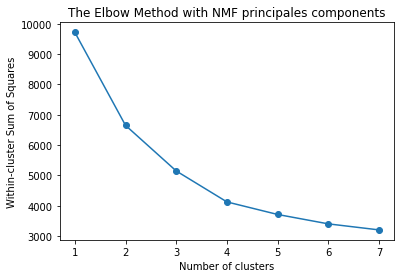

747.6537411212921


In [313]:
# calculate distortion for a range of number of cluster
distortions_nmf = []
best_params_nmf = []
Y_km_NMF = [] 
km_best = []
silhouette_scores = []
time_start = time.time()


#generate random indexes to increase calc speed
randomIndexes = np.random.choice(X_nmf_projected.shape[0], 
                                  size=40000, 
                                  replace=False)
X_nmf_projected_light = X_nmf_projected[randomIndexes]


for i in range(1, 8):
    param_grid = [{
    "n_clusters": [i],
    "max_iter": [1000],
    "tol": np.logspace(-1, 1, 5),
    "init": ["random", "k-means++"],
    "n_init": range(5, 16, 5),
    "random_state": range(0, 16, 5)
}]
    km = KMeans()
    kmElbow = GridSearchCV(km, param_grid)
    kmElbow.fit(X_nmf_projected)
    print(i, " Best Params", kmElbow.best_params_)
    best_params_nmf.append(kmElbow.best_params_)
    distortions_nmf.append(kmElbow.best_estimator_.inertia_)
    
    y_km = kmElbow.best_estimator_.predict(X_nmf_projected)
    
    if i > 1:
        silhouette__coef = silhouette_score(X_nmf_projected, y_km)
        silhouette_scores.append(silhouette__coef)
    
    print(y_km)
    km_best.append(kmElbow.best_estimator_)   
    Y_km_NMF.append(y_km)

# plot
plt.plot(range(1, 8), distortions_nmf, marker='o')
plt.title('The Elbow Method with NMF principales components')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares')
plt.show()
print(str(time.time()-time_start))

Avec le PCA, il n'y a pas de coude qui se démarque. Nous ne privilegierons pas cette approche.

### Store dataframe of returning and non returning customer. 

In [355]:
XRetungingIndexes = rawFrame.loc[rawFrame["returningCustomers"] == 1].values
XNonRetungingIndexes = rawFrame.loc[rawFrame["returningCustomers"] == 0].values

X_NMF_RetungingIndexes = nmf.transform(minMaxEncoder.transform(XRetungingIndexes))
X_NMF_Non_RetungingIndexes = nmf.transform(minMaxEncoder.transform(XNonRetungingIndexes))

X_RetungingIndexes_PCA= pca.transform(std_scaler.transform(XRetungingIndexes))
X_Non_RetungingIndexes_PCA = pca.transform(std_scaler.transform(XNonRetungingIndexes))

X_RetungingIndexes_scaled = std_scaler.transform(XRetungingIndexes)
X_Non_RetungingIndexes_scaled = std_scaler.transform(XNonRetungingIndexes)

### Draw Centroids In 2D with Scaled Data

['NbReviews', 'avgReviewScore', 'customer_stateEnc', 'nbOrders', 'orderLateBool', 'orderLateInDays', 'orderStatusBool', 'order_delivery_length', 'payment_sequential', 'payment_typeEnc', 'price', 'product_category_nameEnc', 'returningCustomers', 'review_score', 'year']
{'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 3, 'n_init': 10, 'random_state': 5, 'tol': 0.1}
current cluster  2
current cluster  3
current cluster  4
current cluster  5
current cluster  6


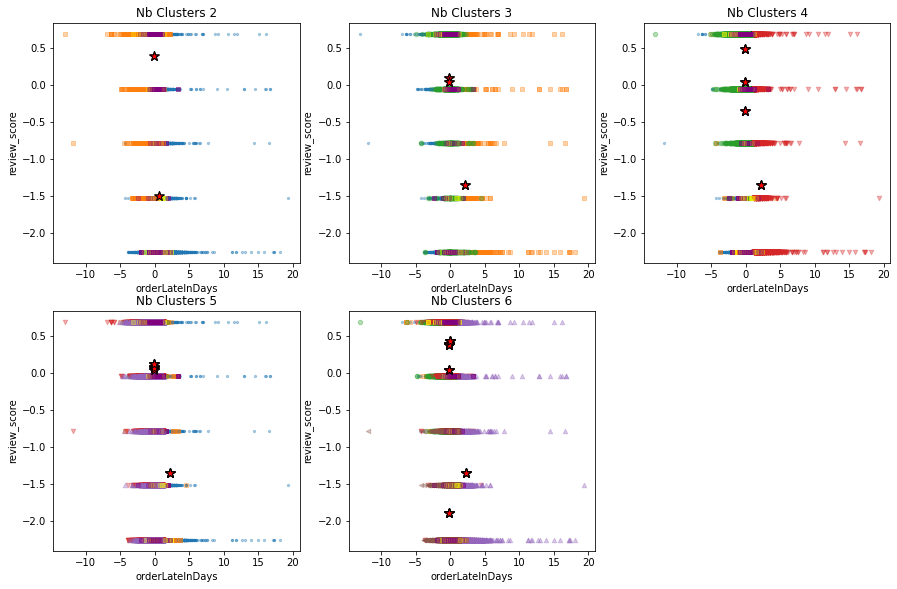

In [352]:
from sklearn.cluster import KMeans
print(filterC)

#we are gonna use the best model so far for visualisation 
print(best_params_nmf[2])

columns = list(rawFrame.columns.values)
silhouette_coefs = []
scatter = plt.figure(figsize=(15,15))
subplotIndex = 1
clusterRange = 7


#not bad pca1 = 0 and pca2=4
#good pca1 = 1 and pca2=4

pca1 = 5
pca2 = 13

for cluster in range(2, clusterRange):
    y_km = Y_km_NMF[cluster-1]
    
    print("current cluster ", cluster)

    # plot the n clusters
    ax = scatter.add_subplot(int(clusterRange-4), int(clusterRange-4), subplotIndex)
    for plot in range(0, cluster):
        current_cluster = plot

        ax.scatter(
            X_scaled[Y_km_scaled[cluster-1] == plot, pca1],
            X_scaled[Y_km_scaled[cluster-1] == plot, pca2],
            s=20,
            marker=markersList[plot],
            alpha=0.35,
            label='cluster '+str(plot+1)
        )
        ax.set_ylabel(str(columns[pca2]))
        ax.set_xlabel(str(columns[pca1]))
        ax.set_title("Nb Clusters "+ str(cluster))
        ax.set_label('cluster '+str(plot+1))
        # plot the centroids

        ax.scatter(X_RetungingIndexes_scaled[:100, pca1],
                   X_RetungingIndexes_scaled[:100, pca2], marker="s", color="yellow", alpha=0.3, s=15)

        ax.scatter(X_Non_RetungingIndexes_scaled[:100, pca1],
                   X_Non_RetungingIndexes_scaled[:100, pca2], marker="s", color="purple", alpha=0.3, s=15)

        ax.scatter(
            km_best_scaled[cluster-1].cluster_centers_[:, pca1], km_best_scaled[cluster-1].cluster_centers_[:, pca2],
            s=100, marker='*',
            c='red', edgecolor='black',
            label='centroids'
        )
    subplotIndex = subplotIndex+1

### Draw Centroids In 2D with PCA

current cluster  2
current cluster  3
current cluster  4
current cluster  5
current cluster  6


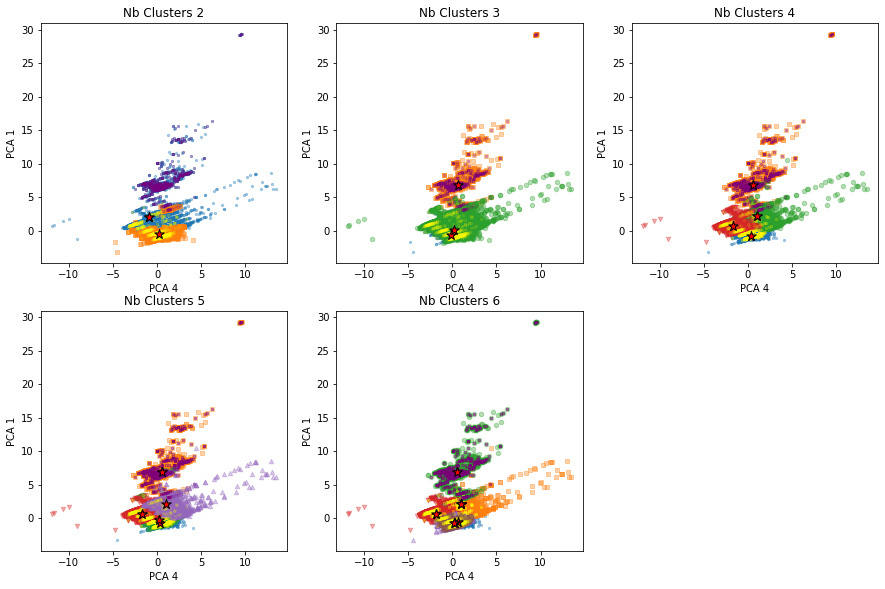

In [385]:
#we are gonna use the best model so far for visualisation 
scatter = plt.figure(figsize=(15,15))
subplotIndex = 1
clusterRange = 7


#not bad pca1 = 0 and pca2=4
#good pca1 = 1 and pca2=4

pca1 = 3
pca2 = 0

for cluster in range(2, clusterRange):
    y_km = Y_km_pca[cluster-1]
    
    print("current cluster ", cluster)

    # plot the n clusters
    ax = scatter.add_subplot(int(clusterRange-4), int(clusterRange-4), subplotIndex)
    for plot in range(0, cluster):
        current_cluster = plot

        ax.scatter(
            X__pca_projected[y_km == plot, pca1],
            X__pca_projected[y_km == plot, pca2],
            s=20,
            marker=markersList[plot],
            alpha=0.35,
            label='cluster '+str(plot+1)
        )
        ax.set_ylabel("PCA " + str(pca2+1))
        ax.set_xlabel("PCA " + str(pca1+1))
        ax.set_title("Nb Clusters "+ str(cluster))
        ax.set_label('cluster '+str(plot+1))
        # plot the centroids

        ax.scatter(X_Non_RetungingIndexes_PCA[:1000, pca1],
                   X_Non_RetungingIndexes_PCA[:1000, pca2], marker="s", color="yellow", alpha=0.1, s=5)

        ax.scatter(X_RetungingIndexes_PCA[:1000, pca1],
                   X_RetungingIndexes_PCA[:1000, pca2], marker="s", color="purple", alpha=0.1, s=5)

        ax.scatter(
            km_best_pca[cluster-1].cluster_centers_[:, pca1], km_best_pca[cluster-1].cluster_centers_[:, pca2],
            s=100, marker='*',
            c='red', edgecolor='black',
            label='centroids'
        )
    subplotIndex = subplotIndex+1

### Draw Centroids In 2D with NMF

['NbReviews', 'avgReviewScore', 'customer_stateEnc', 'nbOrders', 'orderLateBool', 'orderLateInDays', 'orderStatusBool', 'order_delivery_length', 'payment_sequential', 'payment_typeEnc', 'price', 'product_category_nameEnc', 'returningCustomers', 'review_score', 'year']
{'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 3, 'n_init': 10, 'random_state': 5, 'tol': 0.1}
current cluster  2
current cluster  3
current cluster  4
current cluster  5
current cluster  6


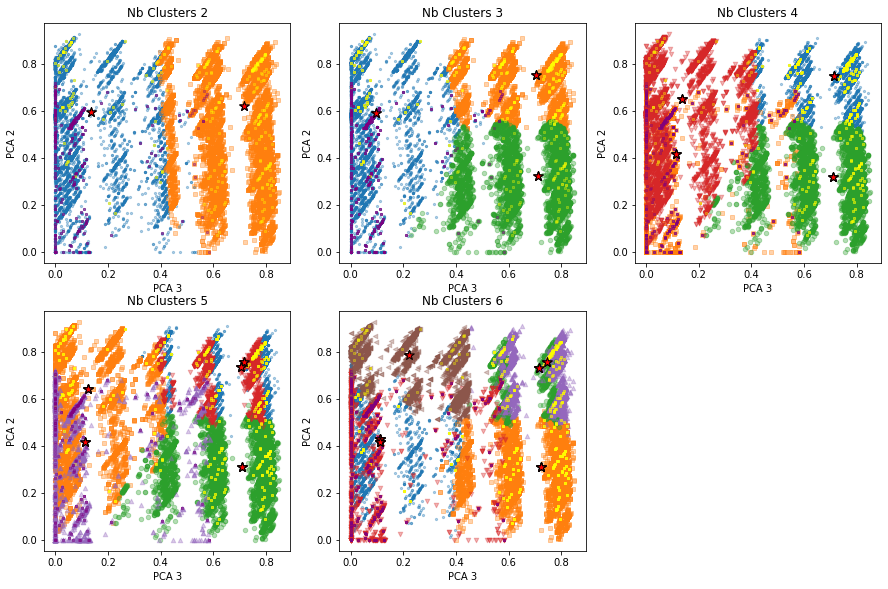

In [399]:
from sklearn.cluster import KMeans
print(filterC)

#we are gonna use the best model so far for visualisation 
print(best_params_nmf[2])

columns = list(rawFrame.columns.values)
silhouette_coefs = []
scatter = plt.figure(figsize=(15,15))
subplotIndex = 1
clusterRange = 7


#not bad pca1 = 0 and pca2=4
#good pca1 = 2 and pca2=1

pca1 = 2
pca2 = 1

for cluster in range(2, clusterRange):
    y_km = Y_km_NMF[cluster-1]
    
    print("current cluster ", cluster)

    # plot the n clusters
    ax = scatter.add_subplot(int(clusterRange-4), int(clusterRange-4), subplotIndex)
    for plot in range(0, cluster):
        current_cluster = plot

        ax.scatter(
            X_nmf_projected[y_km == plot, pca1],
            X_nmf_projected[y_km == plot, pca2],
            s=20,
            marker=markersList[plot],
            alpha=0.35,
            label='cluster '+str(plot+1)
        )
        ax.set_ylabel("PCA " + str(pca2+1))
        ax.set_xlabel("PCA " + str(pca1+1))
        ax.set_title("Nb Clusters "+ str(cluster))
        ax.set_label('cluster '+str(plot+1))
        # plot the centroids

        ax.scatter(X_NMF_Non_RetungingIndexes[:300, pca1],
                   X_NMF_Non_RetungingIndexes[:300, pca2], marker="s", color="yellow", alpha=0.3, s=5)

        ax.scatter(X_NMF_RetungingIndexes[:300, pca1],
                   X_NMF_RetungingIndexes[:300, pca2], marker="s", color="purple", alpha=0.3, s=5)

        ax.scatter(
            km_best[cluster-1].cluster_centers_[:, pca1], km_best[cluster-1].cluster_centers_[:, pca2],
            s=100, marker='*',
            c='red', edgecolor='black',
            label='centroids'
        )
    subplotIndex = subplotIndex+1



# Silhouette Coef

Text(0, 0.5, 'Silhouette')

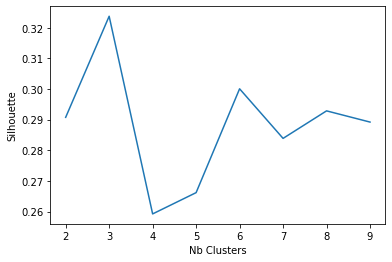

In [150]:
plt.plot(range(2, clusterRange), silhouette_coefs)
plt.xlabel("Nb Clusters")
plt.ylabel("Silhouette")

best nb clusters is 3

# In 3D

['NbReviews', 'avgReviewScore', 'customer_stateEnc', 'nbOrders', 'orderLateBool', 'orderLateInDays', 'orderStatusBool', 'order_delivery_length', 'payment_sequential', 'payment_typeEnc', 'price', 'product_category_nameEnc', 'returningCustomers', 'review_score', 'year']


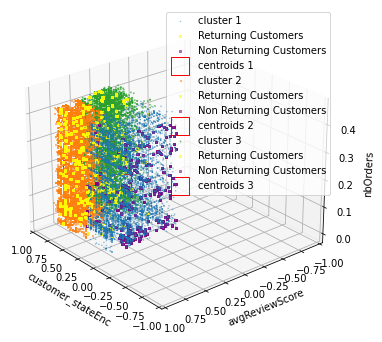

In [409]:
from sklearn.cluster import KMeans
print(filterC)


Xkmeans = mergedFrame1000.dropna().filter(items=filterC).values
#Xkmeans = X_delivered.dropna().filter(items=filterC).sample(1000).values
Xscaled = preprocessing.StandardScaler().fit_transform(Xkmeans)
columns = list(mergedFrame1000.dropna().filter(items=filterC).columns.values)
silhouette_coefs = []
scatter = plt.figure(figsize=(35,35))
subplotIndex = 1
clusterRange = 10

pca1 = 2
pca2 = 1
pca3 = 3

for cluster in range(3, 4):
    km = KMeans(
        n_clusters=cluster,
        n_init=10,
        max_iter=1000,
        tol=10.0,
        random_state=15
    )

    #km.fit_transform(X_factor_projected)
    y_km = Y_km_NMF[cluster-1]
    #silhouette_coef = silhouette_score(X_nmf_projected, y_km)
    #silhouette_coefs.append(silhouette_coef)
    
    ax = scatter.add_subplot(int(clusterRange-5), int(clusterRange-6), subplotIndex, projection='3d')
    for plot in range(0, cluster):
        current_cluster = plot
        #print((cluster-1), (cluster-1), subplotIndex)

        ax.scatter(
            X_nmf_projected[y_km == plot, pca1],
            X_nmf_projected[y_km == plot, pca2],
            X_nmf_projected[y_km == plot, pca3],
            s=1, #c='lightgreen',
            marker=markersList[plot], 
            alpha=0.5,
            #facecolor="none",
            #edgecolor='black',
            label='cluster '+str(plot+1)
        )
        ax.view_init(25, 140)
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_ylabel(str(columns[pca2]))
        ax.set_xlabel(str(columns[pca1]))
        ax.set_zlabel(str(columns[pca3]))
        ax.set_label('cluster '+str(plot+1))
        
        #plot the references for interpretability
        ax.scatter(X_NMF_Non_RetungingIndexes[:300, pca1],
                   X_NMF_Non_RetungingIndexes[:300, pca2], 
                   X_NMF_Non_RetungingIndexes[:300, pca3],
                   label='Returning Customers',
                   marker="s", color="yellow", alpha=0.5, s=5)

        ax.scatter(X_NMF_RetungingIndexes[:300, pca1],
                   X_NMF_RetungingIndexes[:300, pca2], 
                   X_NMF_RetungingIndexes[:300, pca3], 
                   label='Non Returning Customers',
                   marker="s", color="purple", alpha=0.5, s=5)
        
        
        # plot the centroids
        ax.scatter(
        #km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], km.cluster_centers_[:, 2],
         km_best[cluster-1].cluster_centers_[:, pca1], km_best[cluster-1].cluster_centers_[:, pca2], km_best[cluster-1].cluster_centers_[:, pca3],
            s=300, marker='s',
            #c='red', 
            edgecolor='red', 
            facecolor="none", 
            alpha=1,
            label='centroids ' + str(plot+1)
        )
        ax.legend()
    subplotIndex = subplotIndex+1
    #plt.legend(scatterpoints=1)
    #plt.grid()
    #plt.show()

['returningCustomers', 'review_score', 'nbOrders', 'orderStatusBool', 'NbReviews', 'avgReviewScore', 'year', 'orderLateBool', 'seller_stateEnc', 'payment_typeEnc', 'customer_stateEnc', 'order_statusEnc', 'price', 'product_category_nameEnc', 'payment_sequential', 'order_delivery_length', 'orderLateInDays']


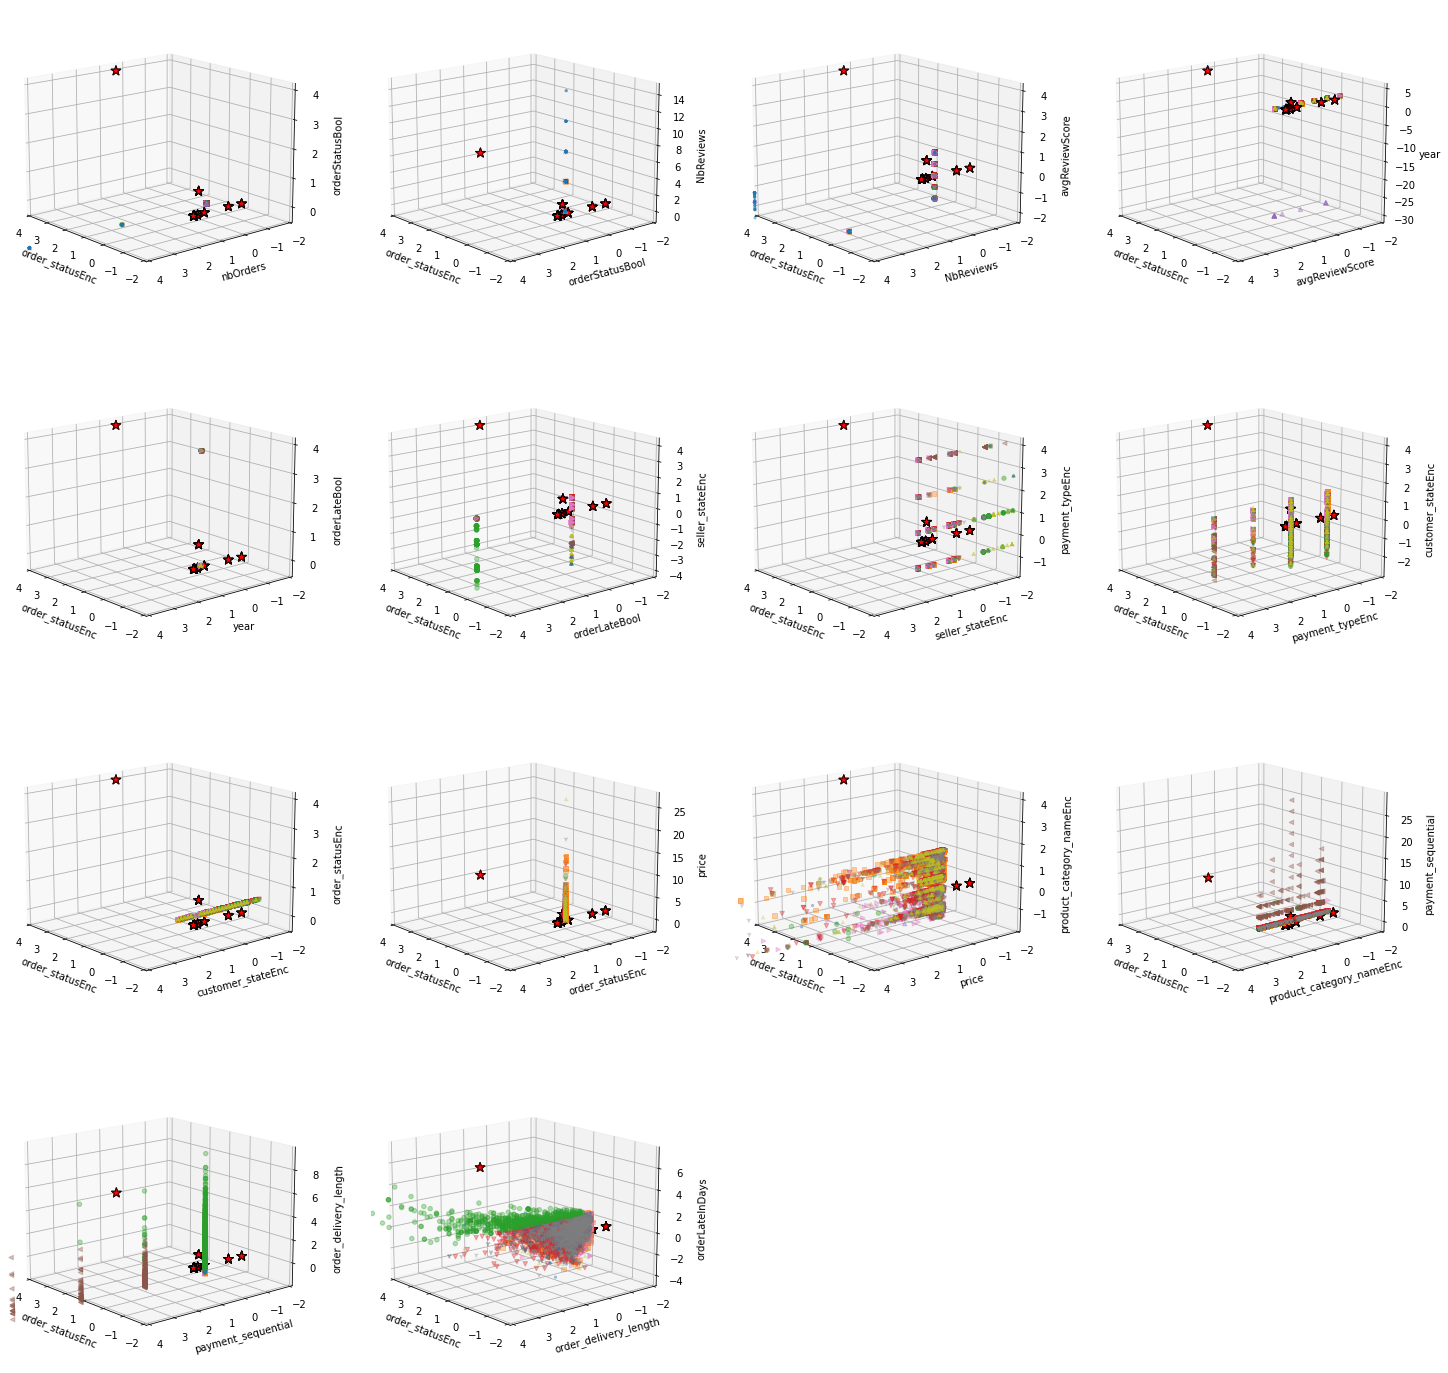

In [48]:
#iterate with the best number of clusters according to silhouette coef
from sklearn.cluster import KMeans
print(filterC)


#Xkmeans = mergedFrame1000.dropna().filter(items=filterC).values
Xkmeans = X_delivered.dropna().filter(items=filterC).values
Xscaled = preprocessing.StandardScaler().fit_transform(Xkmeans)
columns = list(X_delivered.dropna().filter(items=filterC).columns.values)
scatter = plt.figure(figsize=(25,25))
subplotIndex = 1
clusterRange = 10

cluster = cluster

for pca in range(0, (len(columns)-3)):
    km = KMeans(
        n_clusters=cluster,
        init='k-means++',
        n_init=10, max_iter=1000,
        tol=1e-04, random_state=0
    )


    pca1 = 11
    pca2 = pca+2
    pca3 = pca+3
    #km.fit_transform(X_factor_projected)
    y_km = km.fit_predict(Xscaled)
    #print(cluster, "y_km", X_nmf_projected[y_km == 0])
    # plot the n clusters
    ax = scatter.add_subplot(int(clusterRange-6), int(clusterRange-6), subplotIndex, projection='3d')
    for plot in range(0, cluster):
        current_cluster = plot
        #print((cluster-1), (cluster-1), subplotIndex)

        ax.scatter(
            Xscaled[y_km == plot, pca1],
            Xscaled[y_km == plot, pca2],
            Xscaled[y_km == plot, pca3],
            s=20, #c='lightgreen',
            marker=markersList[plot], alpha=0.35,
            #facecolor="none",
            #edgecolor='black',
            label='cluster '+str(plot+1)
        )
        ax.view_init(15, 140)
        ax.set_xlim([-2, 4])
        ax.set_ylim([-2, 4])
        ax.set_ylabel(str(columns[pca2]))
        ax.set_xlabel(str(columns[pca1]))
        ax.set_zlabel(str(columns[pca3]))
        ax.set_label('cluster '+str(plot+1))
        # plot the centroids



        ax.scatter(
        km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], km.cluster_centers_[:, 2],
            s=100, marker='*',
            c='red', edgecolor='black',
            label='centroids'
        )
    subplotIndex = subplotIndex+1
    #plt.legend(scatterpoints=1)
    #plt.grid()
    #plt.show()

# DbScan Clustering


filter ['review_score', 'nbOrders', 'orderStatusBool', 'NbReviews', 'avgReviewScore', 'year', 'orderLateBool', 'seller_stateEnc', 'payment_typeEnc', 'customer_stateEnc', 'order_statusEnc', 'price', 'product_category_nameEnc', 'payment_sequential', 'order_delivery_length', 'orderLateInDays']
[1.00000000e-10 4.89390092e-10 2.39502662e-09 1.17210230e-08
 5.73615251e-08 2.80721620e-07 1.37382380e-06 6.72335754e-06
 3.29034456e-05 1.61026203e-04 7.88046282e-04 3.85662042e-03
 1.88739182e-02 9.23670857e-02 4.52035366e-01 2.21221629e+00
 1.08263673e+01 5.29831691e+01 2.59294380e+02 1.26896100e+03
 6.21016942e+03 3.03919538e+04 1.48735211e+05 7.27895384e+05
 3.56224789e+06 1.74332882e+07 8.53167852e+07 4.17531894e+08
 2.04335972e+09 1.00000000e+10]
columns ['review_score', 'nbOrders', 'orderStatusBool', 'NbReviews', 'avgReviewScore', 'year', 'orderLateBool', 'seller_stateEnc', 'payment_typeEnc', 'customer_stateEnc', 'order_statusEnc', 'price', 'product_category_nameEnc', 'payment_sequential', 

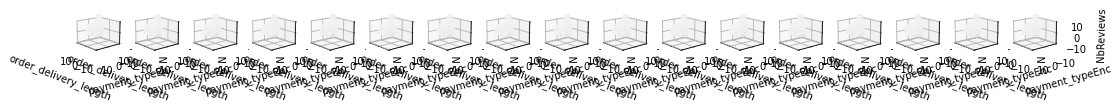

In [49]:
from sklearn.cluster import DBSCAN

#fullFrame = newCols + list(intColumn["columns"].values)
#fullFrame  = fullFrame + list(floatColumn["columns"].values)
#print("Orders value", np.unique(mergedFrame1000["order_statusEnc"].values))

fullFrame = filterC
print("filter", filterC[1:20])

from matplotlib import cm
viridis = cm.get_cmap('Pastel1', 128)

#Xkmeans = mergedFrame1000.dropna().filter(items=filterC).values
#Xkmeans = X_delivered.dropna().filter(items=fullFrame[1:18]).sample(8000).values
Xkmeans = mergedFrame1000.dropna().filter(items=fullFrame[1:20]).sample(8000).values
Xscaled = preprocessing.StandardScaler().fit_transform(Xkmeans)
columns = list(mergedFrame1000.dropna().filter(items=fullFrame[1:20]).columns.values)
silhouette_coefs_dbscan = []
scatter = plt.figure(figsize=(25,25))
subplotIndex = 1
clusterRange = 30

epsRange = np.logspace(-10, 10, clusterRange)
print(epsRange)
print("columns", fullFrame[1:clusterRange])




#print(plt.cm.get_cmap("hsv", 2))

pca1 = 14
pca2 = 8
pca3 = 3

for e in epsRange:
    db = DBSCAN(
        eps=e, min_samples=10
    )
    colors = []
    #km.fit_transform(X_factor_projected)
    dbscan = db.fit(Xscaled)
    Y_dbscan = db.labels_
    #print("Y_dbscan", len(Y_dbscan))
    for y in range(len(Y_dbscan)):
        colors.append(viridis(y))


    #print(np.unique(Y_dbscan))
    if len(np.unique(Y_dbscan)) > 1:# and subplotIndex < len(fullFrame[1:17]):
        silhouette_coef = silhouette_score(Xscaled, Y_dbscan)
        silhouette_coefs_dbscan.append(silhouette_coef)
        #print(silhouette_coef)

        # plot the n clusters
        ax = scatter.add_subplot(int(clusterRange-6), int(clusterRange-6), subplotIndex, projection='3d')
        for plot in range(0, cluster):
            current_cluster = plot
            print((cluster-1), (cluster-1), subplotIndex)

            ax.scatter(
                Xscaled[:, pca1],
                Xscaled[:, pca2],
                Xscaled[:, pca3],
                s=20, #c = Y_dbscan,
                marker=markersList[plot],
                alpha=0.35,
                #facecolor="none",
                facecolor=colors,
                label='cluster '+str(plot+1)
            )
            ax.view_init(15, 140)
            ax.set_xlim([-10, 10])
            ax.set_ylim([-10, 10])
            ax.set_zlim([-10, 10])
            ax.set_ylabel(str(columns[pca2]))
            ax.set_xlabel(str(columns[pca1]))
            ax.set_zlabel(str(columns[pca3]))
            #ax.set_label('cluster '+str(plot+1))
            # plot the centroids

        subplotIndex = subplotIndex+1
    #plt.legend(scatterpoints=1)
    #plt.grid()
    #plt.show()

In [58]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
viridis = cm.get_cmap('Blues', 128)
print(viridis(20))

(0.8461324687355257, 0.9052647830785857, 0.9604755287941948, 1.0)


# Clusters Stability 



In [129]:
mergedFrame1000["quarter"] = mergedFrame1000['order_purchase_timestamp'].dt.quarter
uniqueYears = np.unique(mergedFrame1000["year"].values)

for year in uniqueYears:
    currentYearFrame = mergedFrame1000[mergedFrame1000["year"] == year]
    currentQuarters = np.unique(mergedFrame1000["quarter"].values)
    for quarter in currentQuarters:
        currentQuarter = currentYearFrame[currentYearFrame["quarter"] == quarter]
        if len(currentQuarter['order_purchase_timestamp'].values):
            firstOrder = np.min(currentQuarter['order_purchase_timestamp'].values)
            adjustedFrame = mergedFrame1000[mergedFrame1000['order_purchase_timestamp'] <= firstOrder]
            if len(adjustedFrame) > 100: 
                adjustedFrameNmf = nmf.transform(minMaxScaler.transform(adjustedFrame.filter(items=filterC).dropna().values))
                print(len(adjustedFrameNmf))

226
5235
14624
27778
46000
67494
87025


- Stabilty of the centroids 
- Stabilty of the clusters 

# Returning Customer Caracteristics

In [ ]:
returningC = mergedFrame1000[mergedFrame1000["returningCustomers"] == 1]
NreturningC = mergedFrame1000[mergedFrame1000["returningCustomers"] == 0]

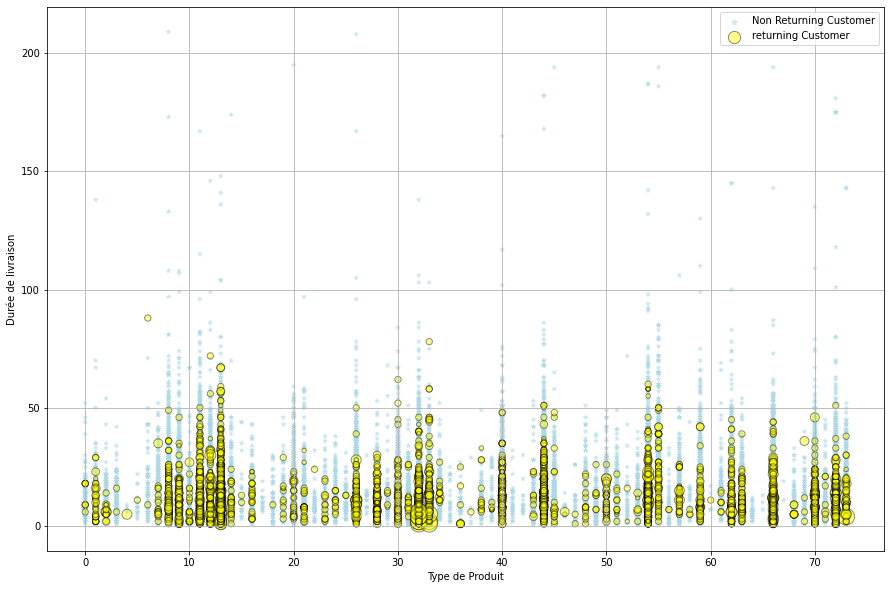

In [68]:
plt.figure(figsize=(15,10))

plt.scatter(NreturningC["product_category_nameEnc"], NreturningC['order_delivery_length'],
            c="lightblue", alpha=0.45,marker="*", s=NreturningC['NbReviews'].values*20,
            label="Non Returning Customer")


plt.scatter(returningC["product_category_nameEnc"], returningC['order_delivery_length'],
            c="yellow", alpha=0.45, edgecolor="black", s=returningC['NbReviews'].values*20,
            label='returning Customer')


plt.grid()
plt.ylabel("Durée de livraison")
plt.xlabel("Type de Produit")
plt.legend(scatterpoints=1)

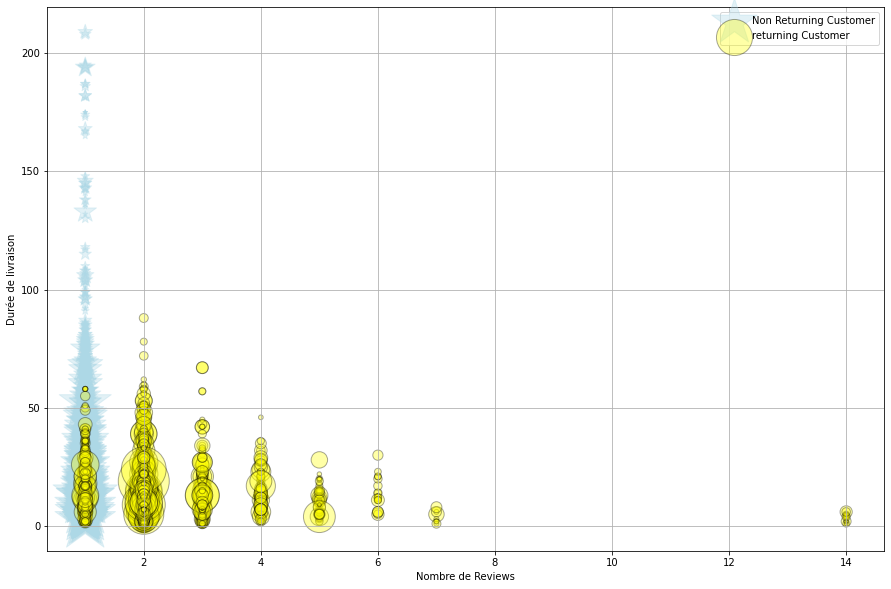

In [69]:
plt.figure(figsize=(15,10))

plt.scatter(NreturningC["NbReviews"], NreturningC['order_delivery_length'],
            c="lightblue", alpha=0.35,marker="*", s=NreturningC['price'].values,
            label="Non Returning Customer")


plt.scatter(returningC["NbReviews"], returningC['order_delivery_length'],
            c="yellow", alpha=0.35, edgecolor="black", s=returningC['price'].values,
            label='returning Customer')


plt.grid()
plt.ylabel("Durée de livraison")
plt.xlabel("Nombre de Reviews")
plt.legend(scatterpoints=1)

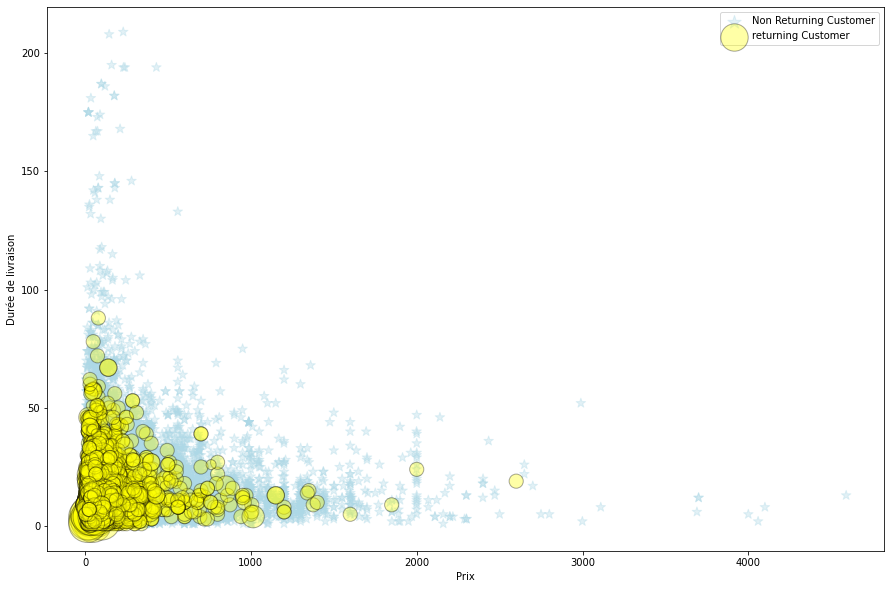

In [65]:
returningC = mergedFrame1000[mergedFrame1000["returningCustomers"] == 1]
NreturningC = mergedFrame1000[mergedFrame1000["returningCustomers"] == 0]

plt.figure(figsize=(15,10))

plt.scatter(NreturningC["price"], NreturningC['order_delivery_length'], s=NreturningC['NbReviews']*100, #projection='3d',
            c="lightblue", alpha=0.35,marker="*",# s=NreturningC['NbReviews'].values*20,
            label="Non Returning Customer")


plt.scatter(returningC["price"], returningC['order_delivery_length'], s=returningC['NbReviews']*100 , #projection='3d',
            c="yellow", alpha=0.35, edgecolor="black", #s=returningC['NbReviews'].values*20,
            label='returning Customer')



plt.ylabel("Durée de livraison")
plt.xlabel("Prix")
plt.legend(scatterpoints=1)

# Old method for feature engineering

In [ ]:
#add NbOrders - much slower
start_time = time.time()
customerIds = mergedFrame1000["customer_unique_id"].values
nbOrders = []
for ids in customerIds:
    idx = mergedFrame1000["customer_unique_id"].loc[mergedFrame1000["customer_unique_id"] == ids]
    orders = mergedFrame1000["order_id"].iloc[idx.index.values]
    uniqueOrders = np.unique(orders.values)
    nbOrders.append(len(uniqueOrders))
mergedFrame1000["nbOrders"] = nbOrders
print(str(time.time()-start_time))

In [ ]:
#add avgReviewScore - with iterrows
start_time = time.time()
customerIds = mergedFrame1000["customer_unique_id"].values
avgReviewScore = []
for index, row in mergedFrame1000.iterrows():
    currentCustomer = row["customer_unique_id"]
    if row["NbReviews"] >=1:
        currentCustomerRows = mergedFrame1000["customer_unique_id"].loc[mergedFrame1000["customer_unique_id"] == currentCustomer]
        filters = mergedFrame1000.iloc[currentCustomerRows.index.values]
        #print(np.unique(currentCustomerRows.index.values))
        avgScore = np.average(filters["review_score"])
        #print(index, avgScore)
        avgReviewScore.append(avgScore)
    else:
        avgReviewScore.append(0)
mergedFrame1000["avgReviewScore"] = avgReviewScore
print(str(time.time()-start_time))

